# HappyCustomer - An Apziva Project

By Samuel Alter

This project centers on a customer survey dataset from a delivery company. The dataset consists of the following:
* `Y`: The target attribute, indicating whether the customer noted their happiness or unhappiness
* `X1`: Order was delivered on time
* `X2`: Contents of the order was as expected
* `X3`: I ordered everything that I wanted to order
* `X4`: I paid a good price for my order
* `X5`: I am satisfied with my courier
* `X6`: The app makes ordering easy for me

Attributes `X1` through `X6` are on a 1 to 5 scale, with 5 indicating most agreement with the statement.

The goals of this project are to train a model that predicts whether a customer is happy or not, based on their answers to the survey. Specifically, I am to reach 73% accuracy or higher with my modeling, or explain why my solution is superior.

A stretch goal would be to determine which features are more important when predicting a customer's happiness. What is the minimal set of attributes or features that would preserve the most information about the problem, while at the same time increasing predictability? The aim here is to see if any question can be eliminated in the next survey round.

The statistical analysis of the features can be found in the [Statistical Modeling](#statistical_modeling) section at the end of this document.

## Table of Contents

1. [EDA](#eda)
1. [Initial `lazypredict` model exploration](#lazy_predict)
1. [`XGBoost` in `sklearn`](#xgboost)

## EDA <a name='eda'></a>

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
df=pd.read_csv('../data/ACME-HappinessSurvey2020.csv')
df.sample(3)

,Y,X1,X2,X3,X4,X5,X6
105,1,5,1,4,3,5,5
3,0,5,4,3,3,3,5
108,0,5,2,4,4,5,5


Let's rename the columns to make them more intuitive.

In [127]:
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

# using alphabet prefixes to ensure correct order of columns

In [128]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset")

There are 126 rows and 7 columns in the dataset


In [129]:
df.describe()

,y,a_time,b_contents,c_complete,d_price,e_courier,f_app
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


It seems like most of the participants in the survey were happy about the time it took to receive the order and app experience, but all of this will require more exploration.

In [130]:
df['y'].value_counts()

1    69
0    57
Name: y, dtype: int64

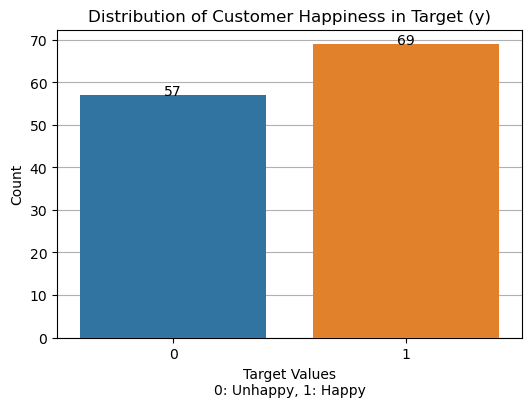

In [131]:
# data labels
x=[0,1]
y=[df['y'].value_counts()[0],df['y'].value_counts()[1]]

plt.figure(figsize=(6, 4))
ax=sns.countplot(data=df, x='y',zorder=3,)
plt.title('Distribution of Customer Happiness in Target (y)')
plt.xlabel('Target Values\n0: Unhappy, 1: Happy')
plt.ylabel('Count')
ax.yaxis.grid(True,zorder=0)
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')
plt.savefig('../figs/1_ydistribution.pdf')
plt.savefig('../figs/1_ydistribution.png')
plt.show()

In [132]:
print(f"In the dataset, {round(df['y'].value_counts()[1]/df['y'].shape[0]*100,2)}% of respondents were happy,\nwhile {round(df['y'].value_counts()[0]/df['y'].shape[0]*100,0)}% of respondents were unhappy.")

In the dataset, 54.76% of respondents were happy,
while 45.0% of respondents were unhappy.


In [133]:
# prepare X data for plotting
col_list=[]

for i in df.columns:
    col_list.append(i)
    
col_list.remove('y')

df_melted=df.melt(value_vars=col_list,var_name='Variable',value_name='Value')

# calculate mean value per variable
mean_values=df_melted.groupby('Variable')['Value'].mean().to_dict()

In [134]:
mean_values

{'a_time': 4.333333333333333,
 'b_contents': 2.5317460317460316,
 'c_complete': 3.3095238095238093,
 'd_price': 3.746031746031746,
 'e_courier': 3.6507936507936507,
 'f_app': 4.253968253968254}

In [135]:
# create custom labels for following figure
labels=[f"{variable}: {mean_values[variable]:.2f}" for variable in mean_values.keys()]
labels

['a_time: 4.33',
 'b_contents: 2.53',
 'c_complete: 3.31',
 'd_price: 3.75',
 'e_courier: 3.65',
 'f_app: 4.25']

In [136]:
df_melted['Variable'].value_counts()

a_time        126
b_contents    126
c_complete    126
d_price       126
e_courier     126
f_app         126
Name: Variable, dtype: int64

In [137]:
xlabs=['Delivery Time',
       'Contents of Order',
       'Order Completeness',
       'Price for Order',
       'Satisfaction with Courier',
       'Satisfaction with App Experience']

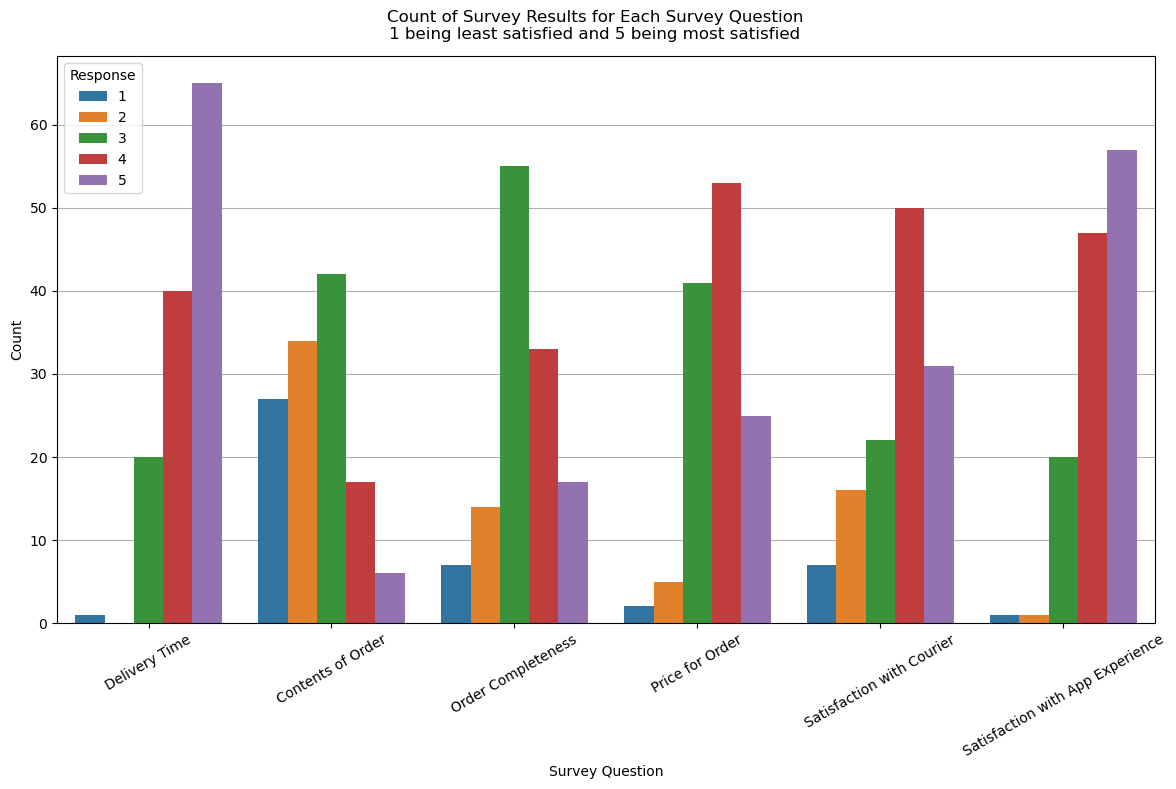

In [138]:
# plot distribution of survey results

plt.figure(figsize=(12,8))
ax=sns.countplot(data=df_melted,x='Variable',hue='Value')
plt.suptitle('Count of Survey Results for Each Survey Question\n1 being least satisfied and 5 being most satisfied')
plt.xlabel('Survey Question')
plt.ylabel('Count')
ax.set_axisbelow(True)
ax.yaxis.grid(True,which='major')
ax.set_xticklabels(xlabs)
plt.xticks(rotation=30)
plt.legend(title='Response',loc='upper left')
plt.tight_layout()
plt.savefig('../figs/1_xdistribution.pdf')
plt.savefig('../figs/1_xdistribution.png')
plt.show()

In [140]:
# setup labels for mean values
mean_values=df_melted.groupby('Variable')['Value'].mean()
mean_values=mean_values.round(decimals=2)
mean_values

Variable
a_time        4.33
b_contents    2.53
c_complete    3.31
d_price       3.75
e_courier     3.65
f_app         4.25
Name: Value, dtype: float64

In [141]:
# data labels
x=[i for i in np.arange(6)]
y=[mean_values[i] for i in np.arange(6)]

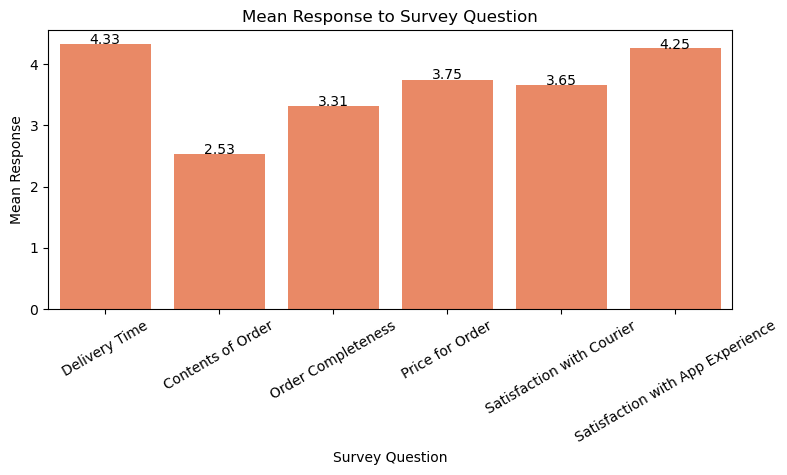

In [142]:
plt.figure(figsize=(10,6))
ax=sns.barplot(data=df_melted,x='Variable',y='Value',ci=None,color='coral')
plt.tight_layout(pad=10)
# plot labels
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha='center')
ax.set_xticklabels(xlabs,rotation=30)
ax.set_title('Mean Response to Survey Question')
ax.set_ylabel('Mean Response')
ax.set_xlabel('Survey Question')
plt.savefig('../figs/1_xmeandistribution.pdf')
plt.savefig('../figs/1_xmeandistribution.png')
plt.show()

The delivery time and app experience had the highest mean satisfaction in the survey, with the contents having the lowest overall.

### EDA Summary

In the dataset that we were given, roughly half of the respondents were unhappy. From a business standpoint, this is an opportunity to increase the amount of satisfied customers. Hence the survey, ostensibly to understand how the company can improve the satisfaction of their customers.

The results from the survey show that the delivery time and the app experience are places where the company is doing well. Areas for improvement are ensuring that the order is prepared correctly and customers being able to find what they need when they place an order.

We need to do more modeling to understand which survey questions are most important and which can be removed. We will do this in the subsequent sections below.

## Run this section in the `lazypredict` environment <a name='lazy_predict'></a>

[`lazypredict`](#https://lazypredict.readthedocs.io/en/latest/) is a very helpful package that can run through generic builds of a multitude of models in order to get a high-level understanding of the performance of these models on your particular dataset. It is a great place to start and saves a lot of time that would be spent manually exploring the accuracy of different models.

In [11]:
import numpy as np
import pandas as pd

In [30]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

In [31]:
# setup random state for reproducibility
random_state=42

In [32]:
# read in and setup dataset

df=pd.read_csv('../data/ACME-HappinessSurvey2020.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

# df.dtypes

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary

In [33]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split(X, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=random_state)

In [34]:
print(f'''
Shapes of splits:
X_train: {X_train.shape}
X_test:  {X_test.shape}
y_train: {y_train.shape}
y_test:  {y_test.shape}
''')


Shapes of splits:
X_train: (100, 6)
X_test:  (26, 6)
y_train: (100,)
y_test:  (26,)



In [35]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     random_state=random_state)

In [36]:
models, predictions = clf.fit(X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test)

100%|█████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 44.32it/s]

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Results from the `LazyClassifier`:  <a name='lazy_predict_results'></a>

In [80]:
models

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,SGDClassifier,0.692308,0.690476,0.690476,0.692308,0.007916
1,NearestCentroid,0.692308,0.684524,0.684524,0.688578,0.007125
2,AdaBoostClassifier,0.692308,0.678571,0.678571,0.680769,0.054332
3,BernoulliNB,0.692308,0.678571,0.678571,0.680769,0.006422
4,DecisionTreeClassifier,0.653846,0.660714,0.660714,0.652308,0.007512
5,RandomForestClassifier,0.653846,0.660714,0.660714,0.652308,0.114229
6,LGBMClassifier,0.653846,0.648810,0.648810,0.652289,0.079940
7,CalibratedClassifierCV,0.653846,0.630952,0.630952,0.617195,0.014890
8,ExtraTreesClassifier,0.615385,0.613095,0.613095,0.615385,0.055475
9,BaggingClassifier,0.615385,0.613095,0.613095,0.615385,0.016343


In [38]:
models.to_csv('../joblib/1_lazypredict.csv')

## Switch to `sklearn` environment <a name='xgboost'></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
models=pd.read_csv('../joblib/1_lazypredict.csv')

In [3]:
models

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,SGDClassifier,0.692308,0.690476,0.690476,0.692308,0.007916
1,NearestCentroid,0.692308,0.684524,0.684524,0.688578,0.007125
2,AdaBoostClassifier,0.692308,0.678571,0.678571,0.680769,0.054332
3,BernoulliNB,0.692308,0.678571,0.678571,0.680769,0.006422
4,DecisionTreeClassifier,0.653846,0.660714,0.660714,0.652308,0.007512
5,RandomForestClassifier,0.653846,0.660714,0.660714,0.652308,0.114229
6,LGBMClassifier,0.653846,0.648810,0.648810,0.652289,0.079940
7,CalibratedClassifierCV,0.653846,0.630952,0.630952,0.617195,0.014890
8,ExtraTreesClassifier,0.615385,0.613095,0.613095,0.615385,0.055475
9,BaggingClassifier,0.615385,0.613095,0.613095,0.615385,0.016343


After exploring alternatives, including `LGBMClassifier`, I will now use `XGBoost` instead - it had given me the second-highest accuracy previously. You'll note that XGBoost is now 25th out of 26 model options. This is a lesson learned that I must always specify a `random_state` to ensure reproducibility.

### Imports

In [4]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
# setup random state for reproducibility
random_state=42

In [6]:
# read in and setup dataset

df=pd.read_csv('../data/ACME-HappinessSurvey2020.csv')

# renaming columns to preserve order
# and make them more intelligible
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

# df.dtypes

X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y'].copy().astype('int8') # because it's a binary

X_train, \
X_test, \
y_train, \
y_test = train_test_split(X, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=random_state)

print(f'''
Shapes of splits:
X_train: {X_train.shape}
X_test:  {X_test.shape}
y_train: {y_train.shape}
y_test:  {y_test.shape}
''')


Shapes of splits:
X_train: (100, 6)
X_test:  (26, 6)
y_train: (100,)
y_test:  (26,)



### Initial model run

In [7]:
xgbc = XGBClassifier(random_state=random_state)
xgbc.fit(X_train, y_train)

y_pred = xgbc.predict(X_test)
print(f'Score on test: {xgbc.score(X_test,y_test)}')
print(classification_report(y_test, y_pred))

Score on test: 0.5384615384615384
              precision    recall  f1-score   support

           0       0.50      0.42      0.45        12
           1       0.56      0.64      0.60        14

    accuracy                           0.54        26
   macro avg       0.53      0.53      0.53        26
weighted avg       0.53      0.54      0.53        26



The base model is not great yet. Let's keep going forward.

Note that the dataset consists of survey responses, which are categorical, but they are not encoded as such. Transforming the survey results into a `category` datatype should help.

In [8]:
for col in X.columns:
    X[col]=X[col].astype('category')
    
print(f'''
Datatypes:

y: 
{y.dtypes}

X: 
{X.dtypes}
''')


Datatypes:

y: 
int8

X: 
a_time        category
b_contents    category
c_complete    category
d_price       category
e_courier     category
f_app         category
dtype: object



### Grid Search Exploration with `XGBoost`

In [17]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score

In [10]:
xgbc = XGBClassifier(random_state=random_state)

# specifying the k-fold so that we can control the randomness
statified_k_fold=StratifiedKFold(n_splits=5,
                                 random_state=random_state,
                                 shuffle=True)

parameters = {
    'alpha': [0], #(list(np.linspace(0,1,3))),
    'gamma': [0], #(list(np.linspace(0,1,3))),
    'lambda': (list(np.linspace(0.275,0.325,6))),
    'learning_rate': (np.logspace(0.211,0.213,9)),
    'max_depth': [2], #(list(np.arange(1,4))),
    'min_child_weight': (list(np.linspace(3.5,4.5,9))),
    'n_estimators': (np.arange(53,58))
}

grid_search = GridSearchCV(xgbc, 
                           parameters, 
                           cv = statified_k_fold, 
                           n_jobs = -1, 
                           verbose = 0)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
             param_grid={'alpha': [0], 'gamma': [0],
                         'lambda': [0.275, 0.28500000000000003,
                                    0.29500000000000004, 0.305, 0.315, 0.325],
                         'learning_rate': array([1.62554876, 1.62648477, 1.62742132, 1.6283584 , 1.62929603,
       1.6302342 , 1.63117291, 1.63211216, 1.63305195]),
                         'max_depth': [2],
                         'min_child_weight': [3.5, 3.625, 3.75, 3.875, 4.0,
                                              4.125, 4.25, 4.375, 4.5],
                         'n_estimators': array([53, 54, 55, 56, 57])})

In [11]:
# best score
print(f"best score: {grid_search.best_score_}")

# best parameters 
print(f"best parameters: {grid_search.best_params_}")

best score: 0.64
best parameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.275, 'learning_rate': 1.625548755750484, 'max_depth': 2, 'min_child_weight': 4.375, 'n_estimators': 53}


List of other best scores below:

```python
best score: 0.64
best parameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.275, 'learning_rate': 1.625548755750484, 'max_depth': 2, 'min_child_weight': 4.375, 'n_estimators': 53}
```

```python
best score: 0.6900000000000001
best parameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.3, 'learning_rate': 1.6292960326397223, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 55}
```

```python
best score: 0.68
best parameters: {'alpha': 0, 'gamma': 0, 'lambda': 0.275, 'learning_rate': 1.6330519478943344, 'max_depth': 2, 'min_child_weight': 3.875, 'n_estimators': 56}
```

Confirm results with running the best parameters again. I will use a pipeline as I want to ensure that I can include a `random_state` and make sure that the model understands that we're dealing with categorical data.

In [67]:
from sklearn.pipeline import Pipeline

# X columns are categorical so they need to be OHE'd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [78]:
# setup classifier
model=XGBClassifier(alpha=0,
                    gamma=0,
                    reg_lambda=0.275,
                    learning_rate=1.625548755750484,
                    max_depth=2,
                    min_child_weight=4.375,
                    n_estimators=53,
                    random_state=random_state)

# preprocessor to handle categorical features, make them OHE'd
# it will ignore any categories that are not found in X_test
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), [0, 1])
    ])

# create pipeline
pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('xgb',model)
])

# allow for five cross-validation folds
statified_k_fold=StratifiedKFold(n_splits=5,
                                 random_state=random_state,
                                 shuffle=True)

# perform cross-validation and print accuracy
scores=cross_val_score(pipeline, 
                       X, 
                       y, 
                       cv=stratified_k_fold, 
                       scoring='accuracy')

print('Cross-validated accuracy: '\
f'{scores.mean()*100:.2f}% ± {scores.std()*100:.2f}%')

Cross-validated accuracy: 61.91% ± 9.64%


### `SGDClassifier`

Per the results from the `lazypredict` [here](#lazy_predict_results), I will switch to the `SGDClassifier`. I will also employ a more in-depth pipeline to include other steps, like `RFE`, for feature elimination. This gets at the stretch goal of the company who gave us the dataset.

We should `OneHotEncode` our dataset before proceeding further.

#### `get_dummies`

In [98]:
X_ohe=pd.get_dummies(data=X,
                     prefix=list(X.columns),
                     drop_first=True)

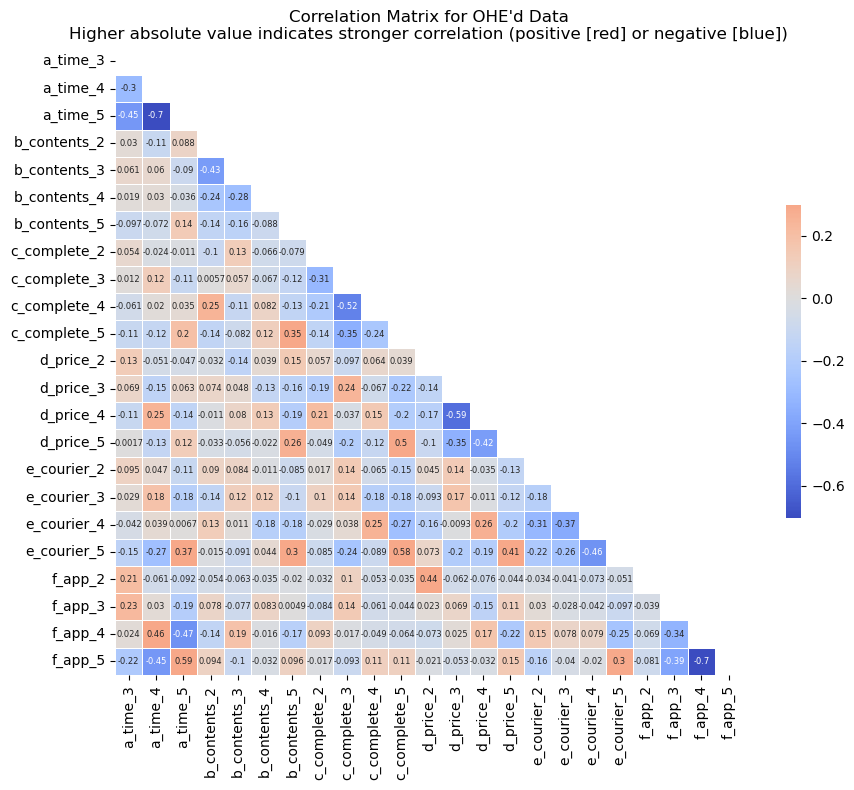

In [117]:
from matplotlib import pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr = X_ohe.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": .5},
            annot_kws={"size":6})
plt.title("Correlation Matrix for OHE'd Data\nHigher absolute value indicates stronger correlation (positive [red] or negative [blue])")
plt.tight_layout()

# save fig
plt.savefig('../figs/1_corrmatrix_ohe.pdf')
plt.savefig('../figs/1_corrmatrix_ohe.png')

Nothing much to learn here except that if a specific category scored high, other categories likely scored high as well.

#### `train_test_split` on newly OHE'd dataset

In [118]:
# train/test split on the OHE'd data
X_train, \
X_test, \
y_train, \
y_test = train_test_split(X_ohe, 
                          y, 
                          test_size=0.2, 
                          stratify=y,
                          random_state=random_state)

In [119]:
# confirm that the split occurred
print(f'''
Shapes of splits:
X_train: {X_train.shape}
X_test:  {X_test.shape}
y_train: {y_train.shape}
y_test:  {y_test.shape}
''')


Shapes of splits:
X_train: (100, 23)
X_test:  (26, 23)
y_train: (100,)
y_test:  (26,)



In [121]:
X_train.sample(3)

,a_time_3,a_time_4,a_time_5,b_contents_2,b_contents_3,b_contents_4,b_contents_5,c_complete_2,c_complete_3,c_complete_4,...,d_price_4,d_price_5,e_courier_2,e_courier_3,e_courier_4,e_courier_5,f_app_2,f_app_3,f_app_4,f_app_5
29,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
84,0,1,0,0,1,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
15,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


#### New Pipeline with `SGDClassifier`

In [122]:
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import BernoulliNB

In [86]:
model = Pipeline(
    steps=[
        ('rfe', RFE(
            estimator=BernoulliNB(),
            n_features_to_select=list(np.arange(1,7)),
            importance_getter='feature_log_prob_'
        )),
        ('bnb', BernoulliNB())
    ]
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

NameError: name 'BernoulliNB' is not defined

In [ ]:
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

### Statistical Modeling <a name="statistical_modeling"></a>

From [this tutorial](#https://www.datacamp.com/tutorial/xgboost-in-python) on DataCamp, I will create a `DMatrix`. This creates an optimized dataframe for memory and speed when performing modeling.

In [15]:
import xgboost as xgb

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)